# INF8825 - Travail pratique 2
___

Claudia Onorato (1845448)

Les deux parties de ce travail ont été réalisé avec William Harvey (1851388).

## Partie I
____

![deepneuralnetwork.png](attachment:deepneuralnetwork.png)

### a) Pseudocode de l'algorithme de rétropropagation
___

L'algorithme de rétropropagation se base sur le calcul de gradients afin d'ajuster tous les poids du modèle en minimisant la fonction de coût. 

La fonction de coût correspond à la cross-entropy lié au softmax: $$L = -\sum_{i=1}^{K} y_i \log(f_i)$$

Celle-ci dépend directement de la fonction d'activation de la dernière couche:

$$f_k = \frac{exp(a_k^{(L+1)})}{\sum_{c=1}^K exp{(a_c^{(L+1)})}}$$

Le résultat de la préactivation équivaut quant à elle à $a^{(L+1)} = \theta^{(L+1)}\hat{h}^{(L)}$.

Par la suite, le calcul de l'activation des couches cachées se font par la fonction `ReLU`: $h^{(L)} = ReLU(a^{(L)})$. 

Afin de bien comprendre les calculs des gradients, il est important de voir la dépendance entre les différentes fonctions et couches. Ci-dessous, nous avons, à la gauche, les dépendances de la dernière couche, suivant la notation de l'énoncé. Ensuite, une exemple d'une couche cachée au centre, puis la première couche à droite.


```
                      θ(L+1)   h(L)        θ(L)    h(L-1)          θ(1)     x 
                        ^       ^           ^       ^               ^       ^            
                        |       |           |       |               |       |        
                        +---+---+           +---+---+               +---+---+          
                            +                   |                       |                 
                          a(L+1)               a(L)        ...         a(1)                    
                            ^                   ^                       ^            
                            |                   |                       |            
                   y        f                   |                       |           
                   ^        ^                  h(L)                    h(1)      
                   |        |
                   +----+---+
                        |
                        +
                        L

```

Pour les calculs des gradients, observons d'abord la dernière couche. Nous allons utiliser la dérivation en chaîne:

$$\frac{\delta L}{\delta\theta^{(L+1)}} = \frac{\delta L}{\delta f} \frac{\delta f}{\delta a^{(L+1)}} \frac{\delta a^{(L+1)}}{\delta\theta^{(L+1)}} $$

$$\frac{\delta L}{\delta\theta^{(L+1)}} = -(y - f^{(L+1)}))\hat{h}^{(L)} = -\Delta^{(L+1)} \hat{h}^{(L)T}$$

Pour les poids des couches cachées, nous calculons les gradients de cette manière, en se basant sur les dérivées partielles des couches supérieures: 

$$\frac{\delta L}{\delta\theta^{(l)}} = -\Delta^{(l)} \frac{\delta a^{(l)}}{\delta\theta^{(l)}}$$

Où:

$$\Delta^{(l)} = \frac{\delta \hat{h}^{(l)}}{\delta a^{(l)}} \frac{\delta a^{(l+1)}}{\delta \hat{h}^{(l)}}\Delta^{(l+1)} = D^{(l)}W^{(l+1)}\Delta^{(l+1)}$$

et

$$\frac{\delta a^{(l)}}{\delta\theta^{(l)}} = \hat{h}^{(l-1)}$$

On a alors:

$$\frac{\delta L}{\delta\theta^{(l)}} = D^{(l)}W^{(l+1)}\Delta^{(l+1)}\hat{h}^{(l-1)}$$

Le calcul de la première couche se fait de la même manière, en remplaçant $\hat{h}^{(l-1)}$ par $\hat{x}$.

Nous pouvons alors formuler le pseudocode suivant:


```python
"""
Entrée:
    theta: 
        vecteurs de poids de dimension
            (M,D+1) pour la 1ere couche,
            (M,M+1) pour les L-1 autres couches cachées et
            (K,M+1) pour la L+1 dernière couche;
    f:
        valeurs d'activation softmax de dimension (K,1)        
    h:
        1 vecteur des valeurs d'entrée de taille (D + 1,1), auxquels on concatène un 1 (pour le biais)
            suivi de
        L vecteurs d'activation de dimension (M + 1,1), auxquels on concatène un 1 (pour le biais).
    a:
        L vecteurs de valeurs de préactivation (M,1)
        1 vecteur de préactivation de taille (K,1) pour la dernière couche
    y:
        One-hot vecteur de la valeur attendue de l'observation de taille (K,1)

Sortie:
    gradients:
        vecteurs de gradients de dimensions
            (M,D+1) pour la 1ere couche,
            (M,M+1) pour les L-1 autres couches cachées et
            (K,M+1) pour la L+1 dernière couche;

Procédure:
"""

# 1. Calcul du gradient pour la dernière couche

current_delta = (y - f)
grads[L+1] = - current_delta * h[L]
previous_delta = current_delta

# 2. On calcule les gradients de l'avant dernière à la première couche
Pour chaque couche l de L à 1:
    
    # 2.1 On calcule la vecteur d qui contient les éléments de la diagonale de D
    #     Contient la dérivée de la fonction d'activation ReLU en fonction de a
    d = [1 if a_element > 0 for a_element in a[l] else 0]
    
    # 2.2 On calcule le delta pour la couche courante où on ignore les biais dans theta
    current_delta = d * (theta[l+1][:,:-1] * previous_delta)
    
    # 2.3 On calcule les gradients pour la couche courante
    grads[l] = - current_delta * h[l-1]
    
    # 2.4 On sauvegarde le delta de la couche courante pour la calcul de la couche (l-1).
    previous_delta = current_delta
    
Retourner grads
```

### b) Implémentation avec et sans Pytorch et comparaison
___

#### 0. Chargement du jeu de données
___

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch

from utils import train, valid, test, experiment

In [2]:
train_set = FashionMNIST(
    root = './data/train-FashionMNIST',
    train = True,
    download = True
)

valid_set = FashionMNIST(
    root = './data/valid-FashionMNIST',
    train = False,
    download = True
)

Expected image is Trouser


/home/william/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/william/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


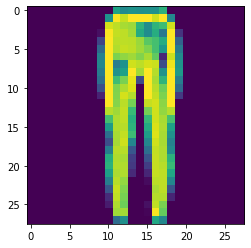

In [3]:
TRAIN_EXAMPLE = 4040
print(f"Expected image is {train_set.classes[train_set.train_labels[TRAIN_EXAMPLE]]}")
plt.imshow(train_set.train_data[TRAIN_EXAMPLE].numpy())

Expected image is Trouser


/home/william/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/william/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


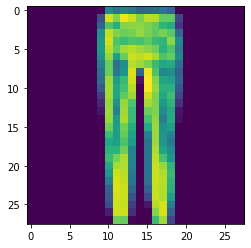

In [4]:
VALID_EXAMPLE = 4039
print(f"Expected image is {valid_set.classes[valid_set.test_labels[VALID_EXAMPLE]]}")
plt.imshow(valid_set.test_data[VALID_EXAMPLE].numpy())

In [5]:
train_X = train_set.train_data.numpy().reshape(train_set.train_data.numpy().shape[0], -1)
train_y = to_categorical(train_set.train_labels.numpy(), num_classes=10)

valid_X = valid_set.test_data.numpy().reshape(valid_set.test_data.numpy().shape[0], -1)
valid_y = to_categorical(train_set.train_labels.numpy(), num_classes=10)

train_X = train_X / 255.
valid_X = valid_X / 255.

print(f"Train set X: {train_X.shape} with y: {train_y.shape}")
print(f"Test set X: {valid_X.shape} with y: {valid_y.shape}")

Train set X: (60000, 784) with y: (60000, 10)
Test set X: (10000, 784) with y: (60000, 10)


#### 1. Implémentation sans Pytorch
___

Lors de l'implémentation à la main du réseau de neurones, j'ai consulté [cet article](https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb) qui monte un réseau de neurones ayant seulement une couche cachée et utilisant les fonctions d'activation sigmoid.

In [6]:
class HandmadeNetwork():
    
    def __init__(self, nb_hidden_layers, nb_inputs=784, nb_units_per_layer=300, nb_class=10):
        self.nb_units_per_layers = [nb_inputs] + [nb_units_per_layer] * nb_hidden_layers + [nb_class]
        self.weights = []
        self.bias = []
        
        for i in range(len(self.nb_units_per_layers)-1):
            print(f"{i}th layer: {self.nb_units_per_layers[i]} -> {self.nb_units_per_layers[i+1]}")
            self.weights.append(
                np.random.normal(0, 0.1, (
                    self.nb_units_per_layers[i+1], 
                    self.nb_units_per_layers[i]
                )))
            self.bias.append(np.random.normal(0, 0.1, (
                    self.nb_units_per_layers[i+1])))

        print(f"Number of weight vectors: {len(self.weights)}")
        print(f"Number of units per layer: {self.nb_units_per_layers}")
        
    
    def fit_transform(self, x, y, batch_size=10, epochs=10, lr = 0.01):
        """
        Updates weights and biases in theta matrix according to this training set
        
        x: inputs of size (nb_inputs=784,)
        y: one-hot encoded vector of size (nb_class=10,)
        batch_size: nb of observations to include in a batch
        epochs: nb of iteration of training over the set
        lr: learning rate
        """
        losses = []
        for e in range(epochs): 
            print(f"Epoch {e}\n")
            i=0
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                grads_w = []
                grads_b = []
                for x_elem, y_elem in zip(x_batch, y_batch):
                    a_s, h_s = self._feedforward(x_elem)
                    dw, db = self._backpropagation(y_elem, a_s, h_s)
                    grads_w.append(dw)
                    grads_b.append(db)

                grads_w = [[grad[i] for grad in grads_w] for i in range(len(grads_w[0]))]
                grads_b = [[grad[i] for grad in grads_b] for i in range(len(grads_b[0]))]

                self.weights = [weights - lr * np.mean(grad) for weights, grad in  zip(self.weights, grads_w)]
                self.bias = [bias - lr * np.mean(grad) for bias, grad in  zip(self.bias, grads_b)]
    
                y_pred = [self.predict(x_elem) for x_elem in x_batch]
                losses.append(self.get_loss(y_batch, y_pred))
            
                i += batch_size

        return losses
    
    def predict(self, x):
        _, h_s = self._feedforward(x)
        return h_s[-1]
    
    def _feedforward(self, x):
        """
        Returns the preactivation and activation values for each layers after forwarding one observation
        
        input
            x: observations of dim (784,)
            
        returns:
            a_s: (avant z_s) preactivation values for each layers and each units
                ** pas de +1 pour le biais dans les dimensions **
            h_s: (avant a_s) activation values for each layers and each units
                Note: last h values corresponds to the activation values f associated with softmax.
                Note: first h values corresponds to the activation values of the input layer, whereas the input x.
                ** pas de +1 pour le biais dans les dimensions **
        """
        h = np.copy(x)
        a_s = []
        h_s = [h]
        
        for i in range(len(self.weights)):
            a = np.add(np.dot(self.weights[i], h), self.bias[i])
            a_s.append(a)
            
            if i == len(self.weights) - 1:
                # calculates last layer activation with stable softmax
                h = self.softmax(a)
                h_s.append(h)
            else:
                # calculates activation with ReLU
                h = self.relu(a)
                h_s.append(h)    

        return a_s, h_s
    
    def _backpropagation(self,y, a_s, h_s):
        """
        Returns the negative gradients for each layers for one observation
        
        Input:
            y: one-hot encoded labels
            a_s: (avant z_s) preactivation values for each layers and each units
                ** pas de +1 pour le biais dans les dimensions **
            h_s: (avant a_s) activation values for each layers and each units
                Note: last h values corresponds to the activation values f associated with softmax.
                Note: first h values corresponds to the activation values of the input layer, whereas the input x.
                ** pas de +1 pour le biais dans les dimensions **
        Returns:
            dtheta: gradient for each weight and biases
        """
        L = len(self.weights)
        dw = [None] * len(self.weights) # dC/dw
        db = [None] * len(self.bias) # dC/db
        
        delta = (y - h_s[-1]) 
        dw[-1] = -np.dot(delta.reshape(delta.shape[0],1), h_s[-2].reshape(h_s[-2].shape[0],1).T)
        db[-1] = -np.sum(delta, axis=0, keepdims=True)
        previous_delta = delta
        
        for l in reversed(range(0, L-1)):
            d = self.relu_differential(a_s[l])
        
            delta = d * (self.weights[l+1].T.dot(previous_delta))    
            dw[l] = - np.dot(delta.reshape(delta.shape[0],1), h_s[l].reshape(h_s[l].shape[0],1).T)
            db[l] = - np.sum(delta, axis=0, keepdims=True)
            previous_delta = delta

        return dw, db
    
    
    def adjust_theta_with_batch(self, weights, bias, grads, lr):
        return (weights - lr * np.mean(grads[0]), bias - lr * np.mean(grads[1]))
        
    @staticmethod
    def relu(x):
        y = np.copy(x)
        y[y<0] = 0
        return y
     
    @staticmethod
    def relu_differential(x):
        y = np.copy(x)
        y[y>=0] = 1
        y[y<0] = 0
        return y
    
    @staticmethod
    def get_hat(h):
        return np.pad(h, (0,1), constant_values=1)
    
    @staticmethod
    def softmax(x):
        # assurez vous que la fonction est numeriquement stable
        # e.g. softmax(np.array([1000, 10000, 100000], ndim=2))
        x = x - max(x)
        exp_sum = sum(np.exp(x))
        return np.exp(x)/exp_sum
    
    @staticmethod
    def get_loss(y, y_pred):
        """
            Returns the loss calculated from the mean negative log likelihood loss function.

            y:      labels of shape (nb_observations, nb_classes)
            y_pred: probabilities for each class and each observation of shape (nb_observations, nb_classes)
        """
        loss = 0
        for i in range(y.shape[0]): # for each observation
            loss += -(y[i] * np.log(y_pred[i])).sum()

        return loss/y.shape[0]


In [11]:
BATCH_SIZE = 100
EPOCHS = 5
LR = 0.001
HIDDEN_LAYERS = 2

In [8]:
%%time
handmade_network = HandmadeNetwork(nb_hidden_layers=HIDDEN_LAYERS)
np_training_losses = handmade_network.fit_transform(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, lr = LR)

0th layer: 784 -> 300
1th layer: 300 -> 300
2th layer: 300 -> 10
Number of weight vectors: 3
Number of units per layer: [784, 300, 300, 10]
Epoch 0

Epoch 1

Epoch 2

CPU times: user 38min 27s, sys: 33min 40s, total: 1h 12min 7s
Wall time: 9min 40s


In [13]:
%%time
y_pred = [np.argmax(handmade_network.predict(x_elem)) for x_elem in valid_X]
y_true = valid_set.train_labels.numpy()
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

Accuracy: 0.0744
CPU times: user 6.26 s, sys: 4.93 s, total: 11.2 s
Wall time: 1.48 s


#### 2. Implémentation avec Pytorch
____

In [14]:
train_set = FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_set = FashionMNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [15]:
train_loader = torch.utils.data.DataLoader(train_set,
    batch_size=BATCH_SIZE, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_set,
    batch_size=BATCH_SIZE, shuffle=True)

In [38]:
class Net(nn.Module):
    def __init__(self, hidden_layers_nb=2, neurons_per_layer=300, dropout=None):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, neurons_per_layer)
        self.hidden_layers = [nn.Linear(neurons_per_layer, neurons_per_layer)] * hidden_layers_nb
        self.fc3 = nn.Linear(neurons_per_layer, 10)
        self.dropout = None
        if dropout:
            self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.dropout(F.relu(x)) if self.dropout else F.relu(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(F.relu(x)) if self.dropout else F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [17]:
neural_net = Net(hidden_layers_nb=HIDDEN_LAYERS, neurons_per_layer=300)
model, precision, pytorch_training_losses = experiment(neural_net, train_loader, valid_loader, epochs=EPOCHS, lr=LR)

/home/william/Documents/PolyDossier/H20/INF8225/utils.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/home/william/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



valid set: Average loss: 0.3488, Accuracy: 8721/10000 (87%)

Training time: 0.0 min. and 33.216105461120605 sec.
Validation time: 0.0 min. and 1.2373027801513672 sec.


#### 3. Comparaison des deux réseaux
___

|                      | Modèle Numpy | Modèle PyTorch |
|:--------------------:|:------------:|:--------------:|
| Temps d'entraînement | 9 min. 40 sec|   51.33 sec.   |
|  Temps de prédiction |   1.48 sec   |   7.49 sec.   |
|       Précision      |      7 %     |      90 %      |

On voit que la version de notre réseau de neurone conçu à l'aide d'une librairie spécialisé comme PyTorch est beaucoup plus performante sur tous les points que notre réseau fait manuellement. Nous pensons que c'est surtout à cause des optimisation algorithmiques (par exemple ADAM), de l'utilisation de tenseurs, l'utilisation sous-jacente de langage bas niveau, une meilleure gestion de la mémoire vive, de la non-présence d'erreur de programmation et de l'optimisation pour le parrallélisme que des librairies comme PyTorch sont largement supérieurs.

**Temps d'exécution:**
___

On voit que le temps d'exécution lorsqu'on utilise la librairie PyTorch est vraiment plus petit que le code que nous avons produit à l'aide de numpy seulement. Notre réseau de neurone prend environ 10 fois moins de temps à entraîner à l'aide de la librairie PyTorch. Cependant, notre code numpy prend moins de temps à faire ses prédictions. Cependant, cela ne veut pas dire grand chose vu les performance de notre réseau...

**Accuracies**
___

C'est bien sûr à ce niveau que les résultats sont le plus frappant. La performance du réseau que nous avons développé à l'aide de Numpy possède une précision qui figure en deça de l'espérance du hasard. Cela est plutôt fâcheux, puisqu'on peut comparer cela avec les performances du réseau développé à l'aide de PyTorch, qui lui, atteint une performance d'environ 90%. Nous sommes donc forcer de constater que notre réseau possède probablement une erreur de programmation importante qui ne permet pas à l'apprentissage de bien se dérouler.

**Évolution du log-loss selon le nombre d'itérations:**
___

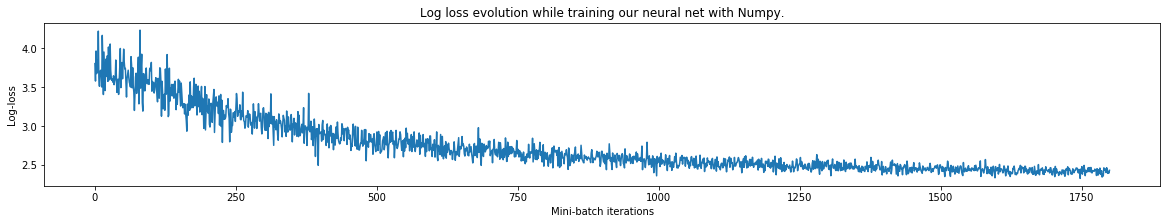

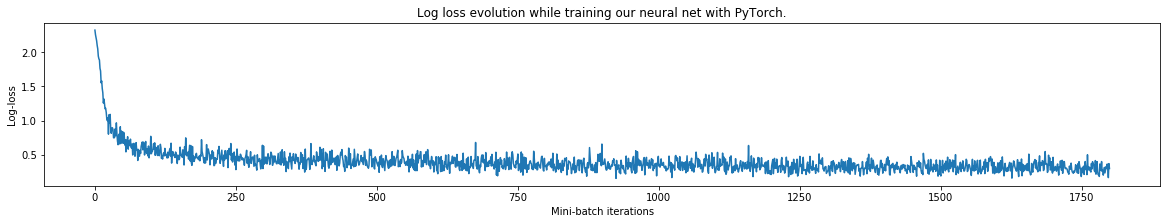

In [18]:
plt.figure(figsize=(20,3))
plt.title('Log loss evolution while training our neural net with Numpy.')
plt.xlabel('Mini-batch iterations')
plt.ylabel('Log-loss')
plt.plot(np_training_losses)
plt.show()

plt.figure(figsize=(20,3))
plt.title('Log loss evolution while training our neural net with PyTorch.')
plt.xlabel('Mini-batch iterations')
plt.ylabel('Log-loss')
plt.plot(pytorch_training_losses)
plt.show()

Ces graphiques montrent l'évolution de notre fonction de perte au fur et à mesure de l'apprentissage effectué par nos réseaux. On voit que le réseau créé à l'aide de PyTorch possède une pente qui est initialement beaucoup plus abrupte. Cela est dû au fait que ce réseau utilise des optimisations tel que ADAM qui permet de converger plus vite vers de bons résultats de prédiction. Globalement, on peut voir que le log-loss de notre réseau PyTorch est beaucoup plus faible que celui créé avec Numpy. Cela explique donc les mauvaises performance de ce dernier par rapport à son équivalent.

Il n'y a donc aucun doute, utilisez une librairie est beaucoup plus facile, performant et beaucoup moins risqué!

## Partie II
___

### 0. Chargement du jeu de données
____

In [3]:
train_set = FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_set = FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_set = FashionMNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [5]:
train_loader = torch.utils.data.DataLoader(train_set,
    batch_size=BATCH_SIZE, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_set,
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set,
    batch_size=BATCH_SIZE, shuffle=True)

### 1. Exploration de différents réseaux
____

### Réseau neuronal pleinement connecté
___

#### a) Nombre de couche
___

In [19]:
HIDDEN_LAYERS_NB = [1,2,3,4]

results = []

for hidden_layers in HIDDEN_LAYERS_NB:
    neural_net = Net(hidden_layers_nb=hidden_layers, neurons_per_layer=300)
    res = experiment(neural_net, train_loader, valid_loader, epochs=EPOCHS, lr=LR)
    results.append(res)


valid set: Average loss: 0.3407, Accuracy: 8768/10000 (88%)

Training time: 0.0 min. and 32.98656177520752 sec.
Validation time: 0.0 min. and 1.2618935108184814 sec.

valid set: Average loss: 0.3550, Accuracy: 8709/10000 (87%)

Training time: 0.0 min. and 34.098313093185425 sec.
Validation time: 0.0 min. and 1.3136699199676514 sec.

valid set: Average loss: 0.3592, Accuracy: 8713/10000 (87%)

Training time: 0.0 min. and 38.561564683914185 sec.
Validation time: 0.0 min. and 1.2689673900604248 sec.

valid set: Average loss: 0.3734, Accuracy: 8630/10000 (86%)

Training time: 0.0 min. and 38.04077482223511 sec.
Validation time: 0.0 min. and 1.3565537929534912 sec.


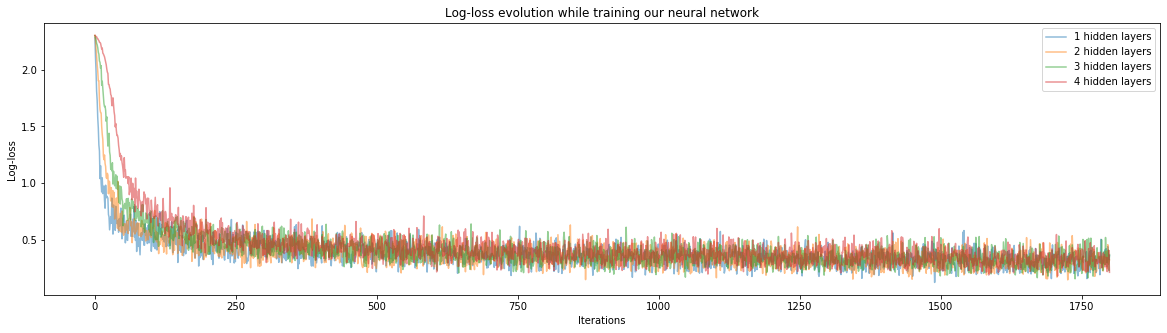

In [26]:
plt.figure(figsize=(20,5))
for i, res in enumerate(results):
    losses = res[2]
    plt.plot(losses, label=f"{HIDDEN_LAYERS_NB[i]} hidden layers", alpha=0.5)
plt.title("Log-loss evolution while training our neural network")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log-loss")
plt.show()

On peut voir ici que moins il y a de couche cachées dans notre réseau, plus l'apprentissage s'effectue rapidement (dès les premières itérations). On peut penser que cela est dû au fait qu'il y a moins de poids à modifier dans un réseau avec moins de couches cachés.

[0.8768, 0.8709, 0.8713, 0.863]


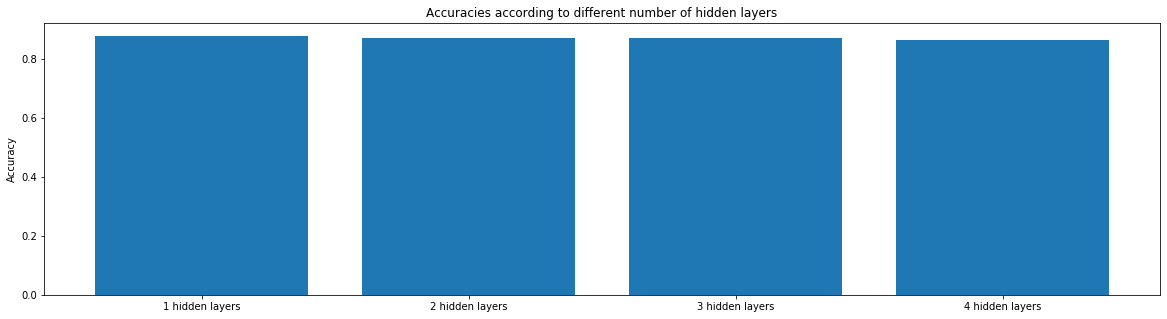

In [32]:
plt.figure(figsize=(20,5))
acc = [res[1] for res in results]
print(acc)
x = [f"{HIDDEN_LAYERS_NB[i]} hidden layers" for i in range(len(results))]
plt.bar(x, acc)
plt.title("Accuracies according to different number of hidden layers")
plt.ylabel("Accuracy")
plt.show()

On peut voir qu'au final, après toutes ces itérations, le réseau a fini par apprendre de la même façon peu importe le nombre de couches. On peut cependant penser, même s'il s'agit de différences très mineures, que moins il y a de couche plus le réseau est préçis dans ses prédictions.

#### b) Nombre de neurones par couche
___

In [33]:
NEURONS_PER_LAYER = [100, 300, 500]

results = []

for neurons_nb in NEURONS_PER_LAYER:
    neural_net = Net(hidden_layers_nb=2, neurons_per_layer=neurons_nb)
    res = experiment(neural_net, train_loader, valid_loader, epochs=EPOCHS, lr=LR)
    results.append(res)


valid set: Average loss: 0.3779, Accuracy: 8644/10000 (86%)

Training time: 0.0 min. and 28.983041286468506 sec.
Validation time: 0.0 min. and 1.2801971435546875 sec.

valid set: Average loss: 0.3506, Accuracy: 8733/10000 (87%)

Training time: 0.0 min. and 36.307960987091064 sec.
Validation time: 0.0 min. and 1.3158414363861084 sec.

valid set: Average loss: 0.3848, Accuracy: 8581/10000 (86%)

Training time: 0.0 min. and 40.94351506233215 sec.
Validation time: 0.0 min. and 1.3754396438598633 sec.


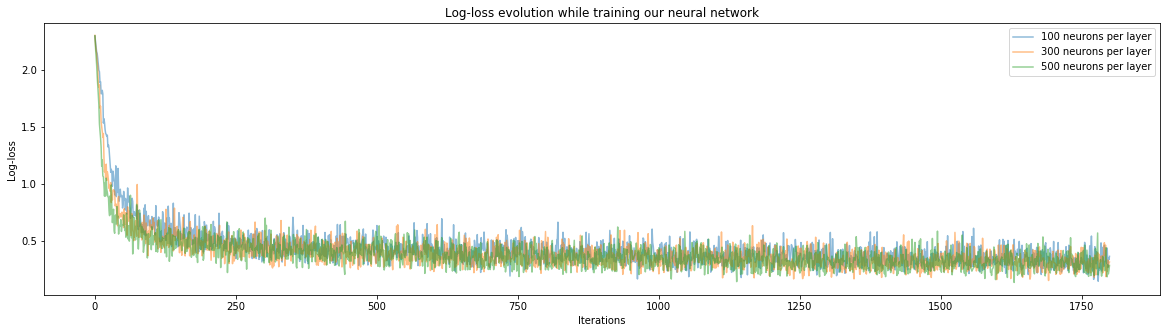

In [34]:
plt.figure(figsize=(20,5))
for i, res in enumerate(results):
    losses = res[2]
    plt.plot(losses, label=f"{NEURONS_PER_LAYER[i]} neurons per layer", alpha=0.5)
plt.title("Log-loss evolution while training our neural network")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log-loss")
plt.show()

Ici, on voit que c'est plutôt lorsqu'il y a le plus de neurones qu'on apprend le plus rapidement.

[0.8644, 0.8733, 0.8581]


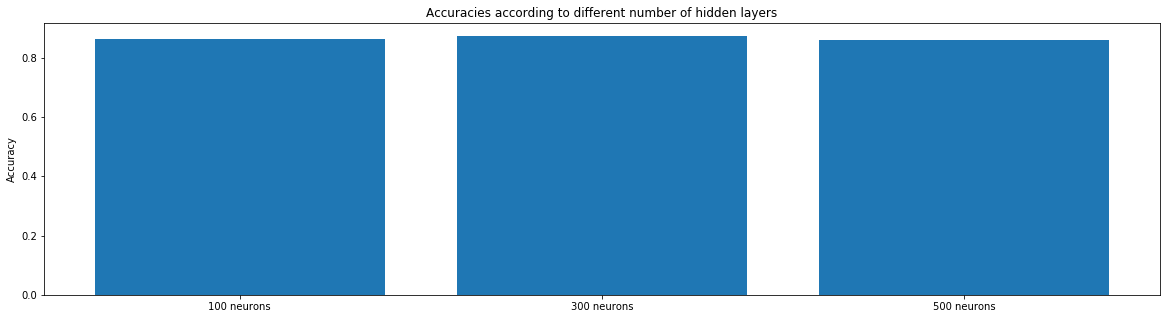

In [36]:
plt.figure(figsize=(20,5))
acc = [res[1] for res in results]
print(acc)
x = [f"{NEURONS_PER_LAYER[i]} neurons" for i in range(len(results))]
plt.bar(x, acc)
plt.title("Accuracies according to different number of neurons")
plt.ylabel("Accuracy")
plt.show()

On peut penser que pour cette configuration de réseau, le meilleur nombre de neurone pour chaque couche caché est d'environ 300.

#### c) Ajout d'un dropout
___

In [39]:
DROPOUTS = [None, 0.1, 0.3]

results = []

for dropout in DROPOUTS:
    neural_net = Net(hidden_layers_nb=2, neurons_per_layer=300, dropout=dropout)
    res = experiment(neural_net, train_loader, valid_loader, epochs=EPOCHS, lr=LR)
    results.append(res)

/home/william/Documents/PolyDossier/H20/INF8225/utils.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/home/william/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



valid set: Average loss: 0.3570, Accuracy: 8677/10000 (87%)

Training time: 0.0 min. and 34.769721269607544 sec.
Validation time: 0.0 min. and 1.2810695171356201 sec.

valid set: Average loss: 0.3749, Accuracy: 8637/10000 (86%)

Training time: 0.0 min. and 35.32728123664856 sec.
Validation time: 0.0 min. and 1.3057799339294434 sec.

valid set: Average loss: 0.4030, Accuracy: 8545/10000 (85%)

Training time: 0.0 min. and 34.96787166595459 sec.
Validation time: 0.0 min. and 1.3039846420288086 sec.


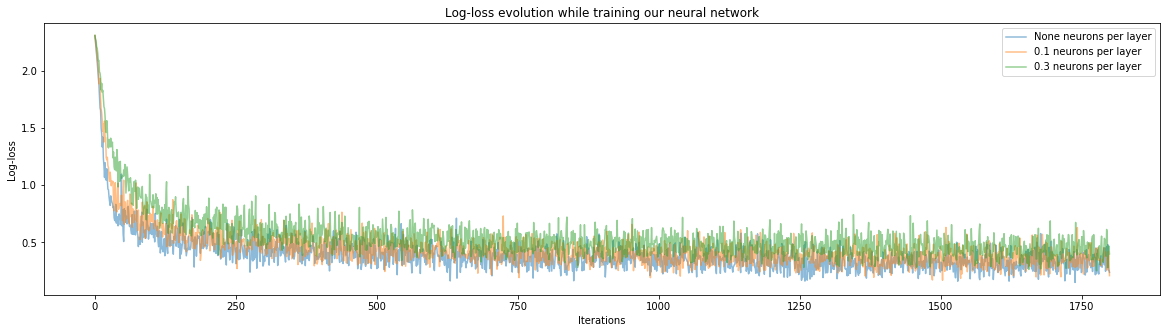

In [40]:
plt.figure(figsize=(20,5))
for i, res in enumerate(results):
    losses = res[2]
    plt.plot(losses, label=f"{DROPOUTS[i]} dropout rate", alpha=0.5)
plt.title("Log-loss evolution while training our neural network")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log-loss")
plt.show()

On peut voir ici, que l'introduction de dropout était probablement une mauvaise idée, puisque plus le dropout est grand, plus l'apprentissage s'effectue lentement. De plus, le log-loss final semble plus élevé, plus il y a de dropout.

[0.8677, 0.8637, 0.8545]


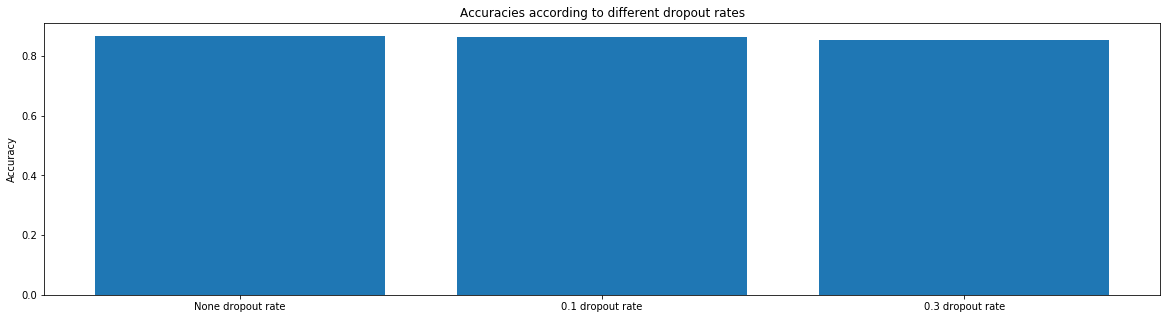

In [41]:
plt.figure(figsize=(20,5))
acc = [res[1] for res in results]
print(acc)
x = [f"{DROPOUTS[i]} dropout rate" for i in range(len(results))]
plt.bar(x, acc)
plt.title("Accuracies according to different dropout rates")
plt.ylabel("Accuracy")
plt.show()

Comme de fait, on obtient une meilleur précision, sans dropout.

### Réseau neuronal convolutif
___

In [9]:
class ConvolutiveNet(nn.Module):
    def __init__(self):
        super(ConvolutiveNet, self).__init__()
        self.layer_one = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer_two = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        x = self.layer_one(x)
        x = self.layer_two(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [12]:
res = experiment(ConvolutiveNet(), train_loader, valid_loader, epochs=EPOCHS, lr=LR)

/home/william/Documents/PolyDossier/H20/INF8225/utils.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/home/william/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



valid set: Average loss: 0.1804, Accuracy: 56091/60000 (93%)

Training time: 1.0 min. and 58.61697602272034 sec.
Validation time: 0.0 min. and 12.120035409927368 sec.


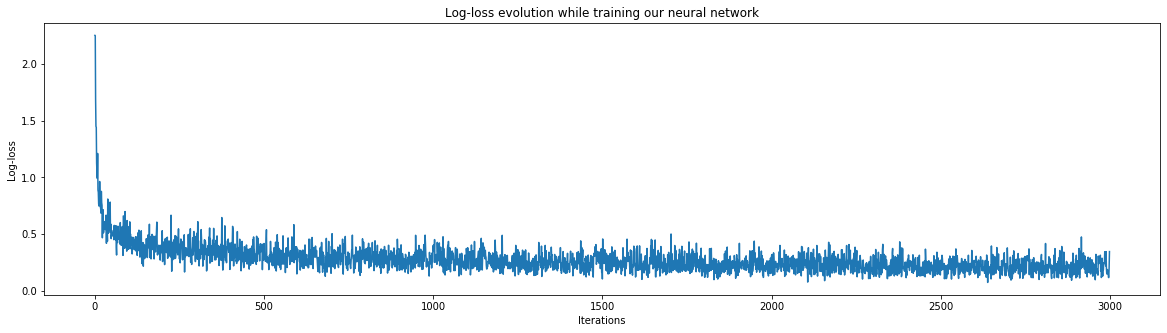

In [13]:
losses = res[2]
plt.figure(figsize=(20,5))
plt.plot(losses)
plt.title("Log-loss evolution while training our neural network")
plt.xlabel("Iterations")
plt.ylabel("Log-loss")
plt.show()

Avec une précision de 90% et un log-loss qui évolue assez rapidement, le réseau neuronal convolutif se montre spécialement bon pour effectuer la classification du dataset Fashion MNIST. Puisqu'il s'agit du modèle que nous avons validé qui performe le mieux, ce sera avec ce modèle que nous allons effectuer nos tests.

In [ ]:
best_model = res[0]

### 2. Sélection du meilleur réseau et évaluation avec les données de test
___


In [14]:
test(best_model, test_loader)

/home/william/Documents/PolyDossier/H20/INF8225/utils.py:52: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



test set: Average loss: 0.2627, Accuracy: 9065/10000 (91%)



(array([6., 9., 8., ..., 3., 4., 3.]), array([6., 9., 8., ..., 3., 4., 3.]))